<font color = "#CC3D3D"><p>
# (DW Practice #2) RFM Analysis

RFM 분석은 Recency(최근성), Frequency(구매빈도), Monetary(구매금액) 이 세가지 기준을 바탕으로 고객을 분류하는 방법론 (*아래 그림은 KTH 사례*)
 - Recency(R): 고객이 얼마나 최근에 구입했는가? 
 - Frequency(F): 고객이 얼마나 빈번하게 구매했는가? 
 - Monetary(M): 고객이 구입한 총 금액은 얼마인가? 
<img align='left' src='http://drive.google.com/uc?export=view&id=1squaxOpxIS1bRJdM3QbzPXZ2dUS9DbYi' style='width: 80%; height: auto;'>

In [1]:
import pandas as pd
from pandas import Series, DataFrame
import numpy as np
import seaborn as sns #아름다운 시각화를 위한 패키지.
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
%matplotlib inline

#pd.set_option('max_columns', 15, 'max_rows', 20)
sns.set_style('whitegrid')

### Data Collection

#### Read Data

In [2]:
cs = pd.read_csv('L사_고객정보.csv')
cs.head()

,clnt_id,clnt_gender,clnt_age
0,1,unknown,unknown
1,2,F,30
2,3,unknown,unknown
3,4,unknown,unknown
4,5,unknown,unknown


In [3]:
gd = pd.read_csv('L사_상품정보.csv')
gd.head()

,pd_c,clac_nm1,clac_nm2,clac_nm3
0,1,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Automobile Oil / Additives
1,2,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Car Lights
2,3,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Car Paint
3,4,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Filters
4,5,Automotive Products,Automotive Replacement Repair / Maintanance Kits,Wiper Blades


In [4]:
tr = pd.read_csv('L사_거래정보.csv')
tr.head()

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct
0,21922,104999,1,A03,unknown,20190920,12:41,5990,1
1,21279,104907,4,A03,unknown,20190920,10:27,10900,1
2,39423,105124,11,A03,unknown,20190920,17:26,12900,1
3,18362,104010,1,A03,unknown,20190920,09:57,9900,1
4,39423,105124,13,A03,0565,20190920,17:26,2990,1


#### Merge Data

In [5]:
gd.pd_c = gd.pd_c.astype(str) # 상품과 거래 데이터의 pd_c(상품소분류코드) 컬럼의 데이터 유형이 서로 달라 맞춰줌 
df = pd.merge(tr, cs).merge(gd, on='pd_c')
df.de_dt = df.de_dt.astype(str).astype('datetime64') # 날짜정보를 담고 있는 de_dt 컬럼의 데이터 유형이 정수이기 때문
df.head()

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct,clnt_gender,clnt_age,clac_nm1,clac_nm2,clac_nm3
0,21922,102455,3,A03,1584,2019-09-18,21:07,2990,1,F,50,Vegetables,Leaf Vegetables,Onions
1,21279,104907,8,A03,1584,2019-09-20,10:27,1000,1,F,40,Vegetables,Leaf Vegetables,Onions
2,21279,105829,14,A03,1584,2019-09-21,13:48,1000,1,F,40,Vegetables,Leaf Vegetables,Onions
3,18362,92227,3,A03,1584,2019-09-06,12:33,2490,1,F,40,Vegetables,Leaf Vegetables,Onions
4,48969,62496,13,A03,1584,2019-08-01,10:59,2590,1,F,40,Vegetables,Leaf Vegetables,Onions


### RFM Calculation

#### Recency value

In [6]:
# 최종 구매일 다음날을 기준으로 계산 
now = df.de_dt.max()+pd.DateOffset(days=1)

#date
# method chaining (multi-line)
recency = (df.groupby('clnt_id')['de_dt']
           .agg(lambda x,y: (y - x).min().days, now).reset_index()
           .rename(columns={'de_dt':'recency'})
          )
recency

,clnt_id,recency
0,2,32
1,9,17
2,20,1
3,23,3
4,24,28
...,...,...
10093,72361,91
10094,72373,15
10095,72400,37
10096,72410,32


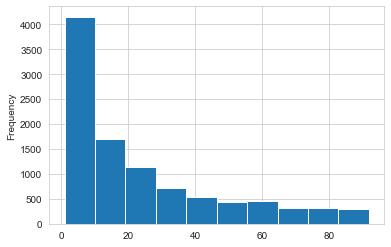

In [7]:
recency.recency.plot.hist()
plt.show()

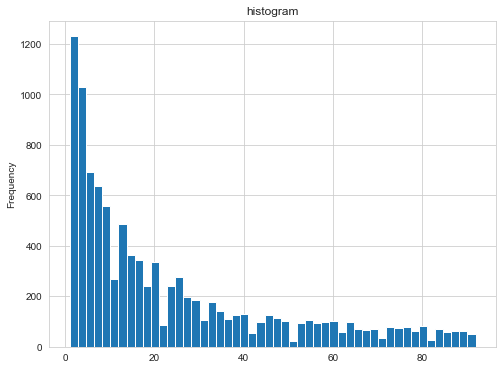

In [11]:
plt.figure(figsize = (8,6))
#figure 사이즈 변경 가능. 
recency.recency.plot.hist(bins =50, title = 'histogram')
plt.show()
#bin의 default는 10, 커질수록 더욱 세부적인 막대그래프를 확인할 수 있음.
#그래프의 타이틀을 설정할 수 있음.

#### Frequency value

In [14]:
frequency =  df.groupby('clnt_id')['trans_id'].agg([('frequency', Series.nunique)]).reset_index()
frequency

,clnt_id,frequency
0,2,2
1,9,7
2,20,4
3,23,6
4,24,2
...,...,...
10093,72361,1
10094,72373,5
10095,72400,3
10096,72410,7


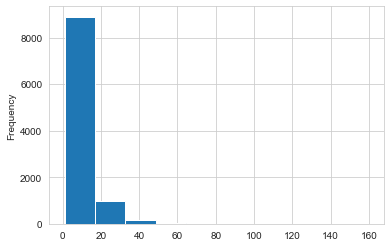

In [15]:
frequency.frequency.plot.hist()
plt.show()

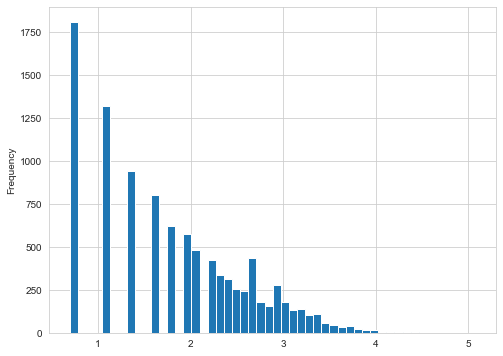

In [16]:
plt.figure(figsize = (8,6))

frequency.frequency.apply(lambda x: np.log1p(x)).plot.hist(bins = 50)
plt.show()

#### Monetary value

In [17]:
monetary = df.groupby('clnt_id')['buy_am'].agg([('monetary', np.sum)]).reset_index()
monetary

,clnt_id,monetary
0,2,58570
1,9,49680
2,20,51430
3,23,50540
4,24,19840
...,...,...
10093,72361,274930
10094,72373,544710
10095,72400,256900
10096,72410,128760


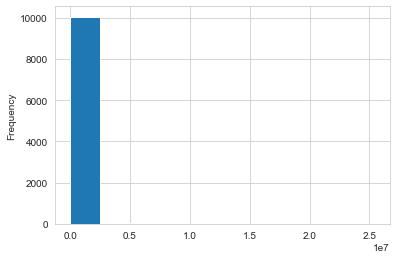

In [18]:
monetary.monetary.plot.hist()
plt.show()

#### RFM score

In [21]:
# 위에서 만든 3개의 data_frame를 merge
rfm = recency.merge(frequency).merge(monetary)
rfm

,clnt_id,recency,frequency,monetary
0,2,32,2,58570
1,9,17,7,49680
2,20,1,4,51430
3,23,3,6,50540
4,24,28,2,19840
...,...,...,...,...
10093,72361,91,1,274930
10094,72373,15,5,544710
10095,72400,37,3,256900
10096,72410,32,7,128760


In [22]:
# recency, frequency, monetary 값을 각각 5분위로 분류하여 점수 부여
rfm['R'] = pd.qcut(rfm['recency'], q=5, labels=range(5,0,-1)).astype(int)
rfm['F'] = pd.qcut(rfm['frequency'], q=5, labels=range(1,6)).astype(int)
rfm['M'] = pd.qcut(rfm['monetary'], q=5, labels=range(1,6)).astype(int)
rfm

# q 퀀텀으로 분위수를 나타냄.

,clnt_id,recency,frequency,monetary,R,F,M
0,2,32,2,58570,2,1,2
1,9,17,7,49680,3,4,2
2,20,1,4,51430,5,3,2
3,23,3,6,50540,5,3,2
4,24,28,2,19840,2,1,1
...,...,...,...,...,...,...,...
10093,72361,91,1,274930,1,1,5
10094,72373,15,5,544710,3,3,5
10095,72400,37,3,256900,2,2,5
10096,72410,32,7,128760,2,4,4


In [23]:
# R,F,M 점수를 조합하여 RFM 그룹 생성 문자열로 변경후 concat하여 새로운 열에 저장.
rfm['RFMgroup'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)
rfm

,clnt_id,recency,frequency,monetary,R,F,M,RFMgroup
0,2,32,2,58570,2,1,2,212
1,9,17,7,49680,3,4,2,342
2,20,1,4,51430,5,3,2,532
3,23,3,6,50540,5,3,2,532
4,24,28,2,19840,2,1,1,211
...,...,...,...,...,...,...,...,...
10093,72361,91,1,274930,1,1,5,115
10094,72373,15,5,544710,3,3,5,335
10095,72400,37,3,256900,2,2,5,225
10096,72410,32,7,128760,2,4,4,244


In [24]:
# R,F,M 에 대한 중요도를 고려하여 RFM 점수 부여
#가중치를 설정하여 점수를 부여, 이에 대한 값을 분류함.
weights = [4, 2, 4]
rfm['RFMscore'] = weights[0] * rfm['R'] + weights[1] * rfm['F'] + weights[2] * rfm['M']
rfm

,clnt_id,recency,frequency,monetary,R,F,M,RFMgroup,RFMscore
0,2,32,2,58570,2,1,2,212,18
1,9,17,7,49680,3,4,2,342,28
2,20,1,4,51430,5,3,2,532,34
3,23,3,6,50540,5,3,2,532,34
4,24,28,2,19840,2,1,1,211,14
...,...,...,...,...,...,...,...,...,...
10093,72361,91,1,274930,1,1,5,115,26
10094,72373,15,5,544710,3,3,5,335,38
10095,72400,37,3,256900,2,2,5,225,32
10096,72410,32,7,128760,2,4,4,244,32


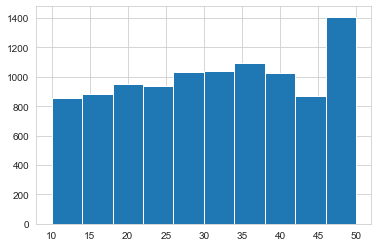

In [28]:
rfm.RFMscore.hist()

In [25]:
rfm.RFMgroup.nunique()
#그룹이 많음. 125의 그룹이지만 해당하는 값이 null 인것이 존재.

119

### Customer Segmentation

#### Segmentation with Recency and Frequency Grid (*source: clevertap*)

<img align='left' src='https://guillaume-martin.github.io/images/rfm-segments.png'>

In [44]:
# 위 그림에 따라 고객 세분화
seg_map = { # replace()에서 정규식 사용
    r'[1-2][1-2]': 'hibernating',
    r'[1-2][3-4]': 'at risk',
    r'[1-2]5': 'can\'t loose them',
    r'3[1-2]': 'about to sleep',
    r'33': 'need attention',
    r'[3-4][4-5]': 'loyal customers',
    r'41': 'promising',
    r'51': 'new customers',
    r'[4-5][2-3]': 'potential loyalists',
    r'54': 'champions',
    r'55': 'champion of champions' #champions 를 두 개의 단계로 나누어 사용함. 
}
#지정된 위치에 매핑함.

rfm['segment'] = rfm['R'].map(str) + rfm['F'].map(str)
rfm['segment'] = rfm['segment'].replace(seg_map, regex=True)
rfm.head()

,clnt_id,recency,frequency,monetary,R,F,M,RFMgroup,RFMscore,segment
0,2,32,2,58570,2,1,2,212,18,hibernating
1,9,17,7,49680,3,4,2,342,28,loyal customers
2,20,1,4,51430,5,3,2,532,34,potential loyalists
3,23,3,6,50540,5,3,2,532,34,potential loyalists
4,24,28,2,19840,2,1,1,211,14,hibernating


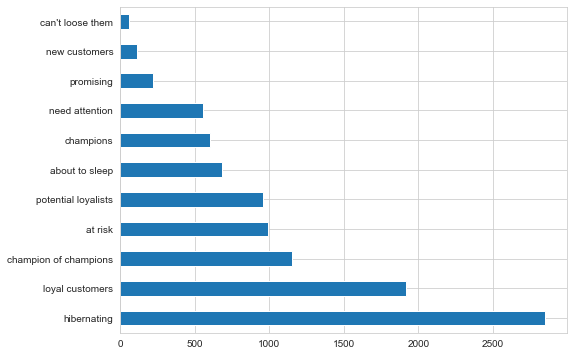

In [45]:
# 세그먼트 별 고객 수
plt.figure(figsize=(8,6))
rfm.segment.value_counts().plot.barh() #barh 수평으로

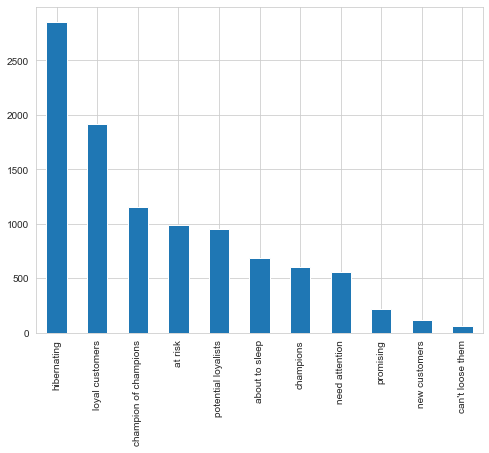

In [46]:
# 세그먼트 별 고객 수
plt.figure(figsize=(8,6))
rfm.segment.value_counts().plot.bar() #수직으로

In [47]:
pd.pivot_table(rfm, index='F', columns='R', values='M', aggfunc=np.mean)#.iloc[::-1,:]

R,1,2,3,4,5
F,,,,,
1,1.829333,2.074733,1.993392,1.866359,1.543860
2,2.495763,2.427007,2.640351,2.073529,2.202899
3,3.005405,3.102970,3.028674,2.875294,2.701538
4,3.804878,3.694656,3.667254,3.581756,3.605307
5,4.125000,4.333333,4.386266,4.285714,4.421739


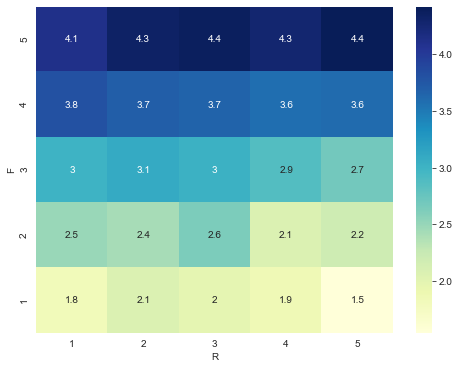

In [48]:
# Recency & Frequency Grid에 Monetary 정보를 추가한 그림

pv = pd.pivot_table(rfm, index='F', columns='R', values='M', aggfunc=np.mean).iloc[::-1,:]
plt.figure(figsize=(8,6))
sns.heatmap(pv, annot=True, cmap="YlGnBu")
#seaborn의 heatmap을 이요하여 정도를 출력.

#### Further Analysis ...

In [49]:
# 추가분석을 위해 RFM 분석결과를 기존 데이터와 병합
md = pd.merge(df, rfm)
md.head()

,clnt_id,trans_id,trans_seq,biz_unit,pd_c,de_dt,de_tm,buy_am,buy_ct,clnt_gender,...,clac_nm3,recency,frequency,monetary,R,F,M,RFMgroup,RFMscore,segment
0,21922,102455,3,A03,1584,2019-09-18,21:07,2990,1,F,...,Onions,13,3,12850,3,2,1,321,20,about to sleep
1,21922,102455,5,A03,1566,2019-09-18,21:07,3890,1,F,...,Cucumbers,13,3,12850,3,2,1,321,20,about to sleep
2,21922,39789,1,A03,1581,2019-07-02,02:24,3780,2,F,...,Jumbo Spring Onions,13,3,12850,3,2,1,321,20,about to sleep
3,21922,39789,2,A03,1183,2019-07-02,02:24,1290,1,F,...,Cookies,13,3,12850,3,2,1,321,20,about to sleep
4,21922,51249,2,A03,1573,2019-07-16,23:21,900,1,F,...,Young Pumpkins,13,3,12850,3,2,1,321,20,about to sleep


In [50]:
# champions 세그먼트의 주요 구매상품 분석
# value_count로 빈도를 분석할 수 있음.
champions = md.query('segment == "champions"').clac_nm2.value_counts().head(5)
champions

Snacks                 2516
Tofu / Bean Sprouts    1575
Instant Noodles        1541
Leaf Vegetables        1238
Biscuits               1137
Name: clac_nm2, dtype: int64

In [51]:
# hibernating 세그먼트의 주요 구매상품 분석
hibernating = md.query('segment == "hibernating"').clac_nm2.value_counts().head(5)
hibernating

Snacks                 1334
Instant Noodles        1136
Tofu / Bean Sprouts     613
Leaf Vegetables         611
Biscuits                594
Name: clac_nm2, dtype: int64

In [52]:
# 위의 두 세그먼트 비교분석
DataFrame({"champions": champions.index, "hibernating": hibernating.index})

,champions,hibernating
0,Snacks,Snacks
1,Tofu / Bean Sprouts,Instant Noodles
2,Instant Noodles,Tofu / Bean Sprouts
3,Leaf Vegetables,Leaf Vegetables
4,Biscuits,Biscuits


In [53]:
# 전체 세그먼트 주요 구매상품 비교분석
DataFrame({seg: md.query('segment == @seg').clac_nm2.value_counts().head(5).index for seg in seg_map.values()})

,hibernating,at risk,can't loose them,about to sleep,need attention,loyal customers,promising,new customers,potential loyalists,champions,champion of champions
0,Snacks,Snacks,Snacks,Snacks,Snacks,Snacks,Snacks,Snacks,Snacks,Snacks,Snacks
1,Instant Noodles,Instant Noodles,Climbing,Instant Noodles,Instant Noodles,Tofu / Bean Sprouts,Instant Noodles,Instant Noodles,Instant Noodles,Tofu / Bean Sprouts,Tofu / Bean Sprouts
2,Tofu / Bean Sprouts,Tofu / Bean Sprouts,Leaf Vegetables,Tofu / Bean Sprouts,Tofu / Bean Sprouts,Instant Noodles,Biscuits,Biscuits,Tofu / Bean Sprouts,Instant Noodles,Leaf Vegetables
3,Leaf Vegetables,Leaf Vegetables,Tofu / Bean Sprouts,Leaf Vegetables,Leaf Vegetables,Leaf Vegetables,Leaf Vegetables,Tofu / Bean Sprouts,Leaf Vegetables,Leaf Vegetables,Fruit Vegetables
4,Biscuits,Fruit Vegetables,Instant Noodles,Biscuits,Fruit Vegetables,Fruit Vegetables,Tofu / Bean Sprouts,Leaf Vegetables,Biscuits,Biscuits,Instant Noodles


### 또 다른 RFM 분석사례 (*FedEx*)
- 대상고객: 전체 4개의 서비스 상품 중 2개의 상품을 구매한 고객
- 대상실적: 최근 6개월간 서비스 이용실적
- 점수부여방식
  - Recency = 최근 3개월 이내 이용 -> 2점, 3개월 이전 이용 -> 1점
  - Frequency = 최근 6개월간총서비스 이용 횟수
  - Monetary = 최근 6개월 간 총 이용금액
- 점수산출방식
  - R점수 * F점수 * M점수
- 관리방식
  - 전체 고객을 총 10개의 군으로 구분하여 관리

<font color = "#CC3D3D"><p>
# End